In [1]:
import os
os.chdir('JQ/PI-SDE')
import pandas as pd
import torch
import matplotlib.pyplot as plt
import re
from types import SimpleNamespace
import numpy as np
from src.evaluation import derive_model
from matplotlib.gridspec import GridSpec
import seaborn as sns

from scipy.stats import ranksums


In [5]:
path = "RESULTS/Weinreb/softplus-400_400-0.5-const-0.1-0.1-0.005/seed_0/alltime/config.pt"
config = SimpleNamespace(**torch.load(path))
model, x, y, device = derive_model(config, ckpt_name = 'epoch_003000')


x_all = torch.cat(x)
y_all_train = list()
for i in range(3):
    y_all_train.extend(np.ones(x[i].shape[0])* y[i] )

xt = torch.cat([x_all, torch.tensor(y_all_train).unsqueeze(1)], dim=1)
potential = model._func._pot(xt.float().to(device)).detach().cpu().numpy()[:,0] 
ci = np.argsort(potential)



/home/shaokun/anaconda3/envs/py-prescient37/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
/home/shaokun/anaconda3/envs/py-prescient37/lib/python3.7/site-packages/seaborn/_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


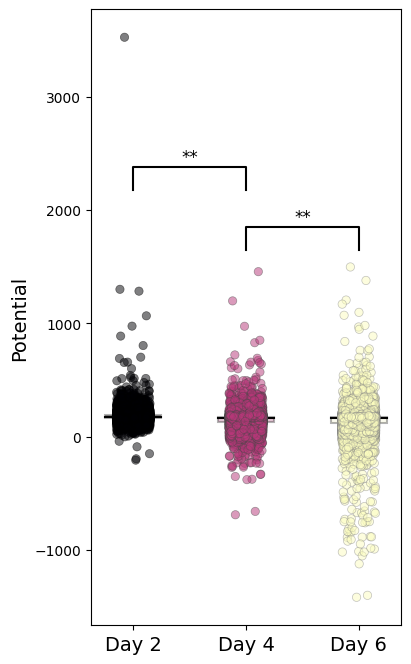

In [6]:
labels_series = pd.Series(y_all_train)
mapping = {2:'Day 2', 4:'Day 4', 6:'Day 6'}
mapped_labels = labels_series.map(mapping)

Times = ['Day 2', 'Day 4', 'Day 6']
data = pd.DataFrame({'Group': mapped_labels, 'Potential': potential})

ps = []
unique_groups = data['Group'].unique()
for i in range(len(unique_groups) - 1):
    group1 = data['Potential'][data['Group'] == unique_groups[i]]
    group2 = data['Potential'][data['Group'] == unique_groups[i + 1]]
    stat, p_value = ranksums(group1, group2, alternative='greater')
    ps.append(p_value)


# Plot
plt.figure(figsize=(4, 8))
palette = plt.cm.magma(np.linspace(0, 1, 3))
sns.boxplot(x='Group', y='Potential', data=data, palette=palette,
            showfliers=False, width=0.5, boxprops=dict(alpha=.3))
sns.stripplot(x='Group', y='Potential', data=data, jitter=0.15, size=6, edgecolor='gray',
              linewidth=0.5, palette=palette, alpha=0.5)


adds = [2000,1500]
for i in range(len(unique_groups) - 1):
    x1, x2 = i, i + 1
    if ps[i] < 1e-60:
        y, h, col = data[data['Group']==Times[i]]['Potential'].mean() + adds[i], 200, 'k'
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
        plt.text((x1 + x2) * .5, y + h+10, "**", ha='center', va='bottom', color=col, fontsize=12)


plt.xlabel("")
plt.xticks(fontsize=14)
plt.ylabel('Potential', fontsize=14)

plt.show()